<a href="https://colab.research.google.com/github/sandeshbhatta495/AI_lab/blob/main/ai_project_cnn_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Classification: Comparing Simple , AlexNet, and TinyVGG


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 1. Data Loading and Augmentation

In [57]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

What Does Data Augmentation Do?

Data augmentation generates new training samples from the original images by applying small transformations such as flipping, rotation, cropping, zooming, or shifting. Instead of feeding the model the exact same image every time, we show it slightly modified versions, which helps prevent the model from memorizing the training data and overfitting. By exposing the model to these variations, it learns general patterns rather than relying on exact pixel positions, becomes more robust to real-world variations, and improves overall generalization and test accuracy. In simple terms, data augmentation makes the dataset appear larger and more diverse, even though no new data was actually collected.

In [58]:
# Loading Dataset CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

In [59]:
# Data Loaders
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Shuffle training data each epoch to avoid order bias
    num_workers=2          # Use 2 background threads to load data faster
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle test data
    num_workers=2
)

In [60]:
# My Data info
CLASS_NAMES = train_dataset.classes
print('Classes:', CLASS_NAMES)
print('\nTraining samples:', len(train_dataset))
print('\nTest samples:', len(test_dataset))

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Training samples: 50000

Test samples: 10000


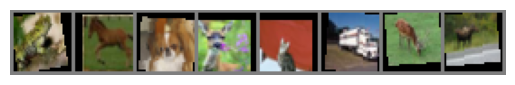

Labels: ['frog', 'horse', 'dog', 'deer', 'cat', 'truck', 'deer', 'deer']


In [61]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img_tensor):
    img_tensor = img_tensor / 2 + 0.5
    np_image = img_tensor.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.axis("off")
    plt.show()

data_iter = iter(train_loader)
sample_images, sample_labels = next(data_iter)

imshow(torchvision.utils.make_grid(sample_images[:8]))
print("Labels:", [CLASS_NAMES[label] for label in sample_labels[:8]])

## 1. For Simple NN

In [62]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()

        # Convert (batch, 3, 32, 32) → (batch, 3072)
        self.flatten = nn.Flatten()

        # Fully Connected Block 1
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        # Fully Connected Block 2
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        # Output layer (10 classes)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)                       # Flatten image
        x = self.dropout1(self.relu1(self.fc1(x)))  # FC1 → ReLU → Dropout
        x = self.dropout2(self.relu2(self.fc2(x)))  # FC2 → ReLU → Dropout
        x = self.fc3(x)                           # Final logits
        return x

### Simple Neural Network, This model treats each image as a flat vector of pixels, here we use Droup out 0.3 mean 30 % of neuron is deselected at training time which prevents model from overfittings

In [63]:
#  Model 2  AlexNet
class AlexNet_CIFAR10(nn.Module):
    def __init__(self):
        super(AlexNet_CIFAR10, self).__init__()

        # Input: (batch, 3, 32, 32)
        self.features = nn.Sequential(
            # Fist layer
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 32x32 → 16x16

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 16x16 → 8x8

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # 8x8 → 4x4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)          # Extract spatial features
        x = torch.flatten(x, 1)       # Flatten: (batch, 256, 4, 4) → (batch, 4096)
        x = self.classifier(x)        # Map features to class logits
        return x

In [64]:
# Model 3: TinyVGG
class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG, self).__init__()
        # Input: (batch, 3, 32, 32)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # 32x32 → 16x16

            # Block 2: increase depth (64 channels)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)     # 16x16 → 8x8
        )

        # Classifier
        # Input size: 64 channels × 8 × 8 = 4096 values
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)     # (batch, 64, 8, 8) → (batch, 4096)
        x = self.classifier(x)
        return x

In [65]:
# Count Trainable Parameters
def count_parameters(model):
    """Return total number of learnable parameters in the model."""
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'  Trainable parameters: {total:,}')
    return total

In [66]:
import time
import torch
import torch.nn as nn

def train_model(model, optimizer, scheduler, num_epochs=20, model_name='Model'):

    criterion = nn.CrossEntropyLoss()  # Multi-class classification loss

    loss_history = []
    accuracy_history = []

    start_time = time.time()  # Track total training time

    for epoch in range(num_epochs):
        # One epoch = model sees entire training dataset once
        model.train()  # Enable training mode (Dropout/BatchNorm active)

        running_loss = 0.0  # Sum of batch losses for this epoch
        correct = 0         # Correct predictions counter
        total = 0           # Total samples counter

        for batch_images, batch_labels in train_loader:
            # Each batch = subset of dataset for faster training

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()  # Clear previous gradients

            outputs = model(batch_images)  # Forward pass
            loss = criterion(outputs, batch_labels)  # Compute batch loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            running_loss += loss.item()

            # Get predicted class indices
            _, predicted_classes = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted_classes == batch_labels).sum().item()

        # Average loss and training accuracy for this epoch
        avg_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct / total

        loss_history.append(avg_loss)
        accuracy_history.append(train_accuracy)

        if scheduler is not None:
            scheduler.step()  # Adjust learning rate

        current_lr = optimizer.param_groups[0]['lr']

        # Print epoch summary
        print(f'{model_name} Epoch {epoch+1}/{num_epochs} | '
              f'Loss: {avg_loss:.4f} | '
              f'Train Acc: {train_accuracy:.2f}% | '
              f'Lr: {current_lr:.6f}')

    total_time = time.time() - start_time
    print(f'[{model_name}] Training finished in {total_time:.1f} seconds')

    return loss_history, accuracy_history, total_time

In [67]:
# Evaluation Function
def evaluate_model(model, model_name='Model'):

    model.eval()  # Set model to evaluation mode (Dropout & BatchNorm disabled)

    correct = 0
    total = 0

    # Disable gradient calculation to save memory and speed up testing
    with torch.no_grad():

        for batch_images, batch_labels in test_loader:
            # Load data to same device (CPU/GPU)
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_images)  # Forward pass only (no backprop)

            # Get class with highest predicted score
            _, predicted_classes = torch.max(outputs, dim=1)

            total += batch_labels.size(0)
            correct += (predicted_classes == batch_labels).sum().item()

    # Accuracy = correct predictions / total samples
    accuracy = 100.0 * correct / total

    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')

    return accuracy

## 4. Train All Three Models


### Model 1: SimpleNN with Adam

In [68]:
# Simple NN
print('Simple Neural Network')
model_simplenn = SimpleNN().to(device)
num_params_simplenn = count_parameters(model_simplenn)

optimizer_adam_nn = optim.Adam(
    model_simplenn.parameters(),
    lr=0.001,
    weight_decay=1e-4  # L2 regularisation
)
#lr shedule
scheduler_nn = optim.lr_scheduler.StepLR(
    optimizer_adam_nn,
    step_size=5,
    gamma=0.5
    )

# Train for 20 epochs
loss_nn, acc_nn, time_nn = train_model(
    model_simplenn, optimizer_adam_nn, scheduler_nn,
    num_epochs=20, model_name='SimpleNN'
)

# Evaluate on test set
test_acc_nn = evaluate_model(model_simplenn, model_name='SimpleNN')

Simple Neural Network
  Trainable parameters: 1,707,274
SimpleNN Epoch 1/20 | Loss: 1.8923 | Train Acc: 31.14% | Lr: 0.001000
SimpleNN Epoch 2/20 | Loss: 1.7721 | Train Acc: 36.03% | Lr: 0.001000
SimpleNN Epoch 3/20 | Loss: 1.7262 | Train Acc: 37.72% | Lr: 0.001000
SimpleNN Epoch 4/20 | Loss: 1.6957 | Train Acc: 38.97% | Lr: 0.001000
SimpleNN Epoch 5/20 | Loss: 1.6763 | Train Acc: 39.69% | Lr: 0.000500
SimpleNN Epoch 6/20 | Loss: 1.6229 | Train Acc: 41.51% | Lr: 0.000500
SimpleNN Epoch 7/20 | Loss: 1.5931 | Train Acc: 42.68% | Lr: 0.000500
SimpleNN Epoch 8/20 | Loss: 1.5821 | Train Acc: 43.31% | Lr: 0.000500
SimpleNN Epoch 9/20 | Loss: 1.5745 | Train Acc: 43.21% | Lr: 0.000500
SimpleNN Epoch 10/20 | Loss: 1.5599 | Train Acc: 43.95% | Lr: 0.000250
SimpleNN Epoch 11/20 | Loss: 1.5266 | Train Acc: 45.30% | Lr: 0.000250
SimpleNN Epoch 12/20 | Loss: 1.5210 | Train Acc: 45.44% | Lr: 0.000250
SimpleNN Epoch 13/20 | Loss: 1.5092 | Train Acc: 45.93% | Lr: 0.000250
SimpleNN Epoch 14/20 | Loss: 1

### Model 2: AlexNet with SGD + Momentum

In [71]:
# Model 2 : AlexNet
print("Ale")
model_alexnet = AlexNet_CIFAR10().to(device)
num_params_alexnet = count_parameters(model_alexnet)

optimizer_sgd_alexnet = optim.SGD(
    model_alexnet.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4  # L2 regularisation
)
# lr scheduler
scheduler_alexnet = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_sgd_alexnet,
    T_max=30,
    eta_min=1e-4
)

# Train for 30 epochs (CNNs need more time to converge)
loss_alexnet, acc_alexnet, time_alexnet = train_model(
    model_alexnet, optimizer_sgd_alexnet, scheduler_alexnet,
    num_epochs=20, model_name='AlexNet'
)

test_acc_alexnet = evaluate_model(model_alexnet, model_name='AlexNet')

Ale
  Trainable parameters: 4,483,146
AlexNet Epoch 1/20 | Loss: 2.3018 | Train Acc: 11.07% | Lr: 0.009973
AlexNet Epoch 2/20 | Loss: 2.0494 | Train Acc: 22.21% | Lr: 0.009892
AlexNet Epoch 3/20 | Loss: 1.7752 | Train Acc: 32.44% | Lr: 0.009758
AlexNet Epoch 4/20 | Loss: 1.5885 | Train Acc: 40.11% | Lr: 0.009572
AlexNet Epoch 5/20 | Loss: 1.4545 | Train Acc: 45.70% | Lr: 0.009337
AlexNet Epoch 6/20 | Loss: 1.3485 | Train Acc: 50.20% | Lr: 0.009055
AlexNet Epoch 7/20 | Loss: 1.2440 | Train Acc: 54.42% | Lr: 0.008729
AlexNet Epoch 8/20 | Loss: 1.1620 | Train Acc: 57.40% | Lr: 0.008362
AlexNet Epoch 9/20 | Loss: 1.0987 | Train Acc: 60.12% | Lr: 0.007960
AlexNet Epoch 10/20 | Loss: 1.0217 | Train Acc: 63.15% | Lr: 0.007525
AlexNet Epoch 11/20 | Loss: 0.9597 | Train Acc: 65.40% | Lr: 0.007063
AlexNet Epoch 12/20 | Loss: 0.9136 | Train Acc: 67.26% | Lr: 0.006580
AlexNet Epoch 13/20 | Loss: 0.8512 | Train Acc: 69.73% | Lr: 0.006079
AlexNet Epoch 14/20 | Loss: 0.8186 | Train Acc: 70.84% | Lr: 

### Model 3: TinyVGG (opti. SGD + Momentum)

In [75]:
# Model 3: TinyVGG
model_tinyvgg = TinyVGG().to(device)  # Initialize model and move to GPU/CPU
num_params_tinyvgg = count_parameters(model_tinyvgg)  # Count total trainable parameters

# Optimizer: SGD with momentum and weight decay for regularization
optimizer_sgd_vgg = torch.optim.SGD(
    model_tinyvgg.parameters(),
    lr=0.05,
    momentum=0.9,
    weight_decay=5e-4
)

# Learning rate scheduler: Cosine Annealing
scheduler_tinyvgg = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_sgd_vgg,
    T_max=30,      # Number of epochs per cycle
    eta_min=1e-4   # Minimum learning rate
)

# Train the model and get per-epoch loss and accuracy
loss_tinyvgg, acc_tinyvgg, time_tinyvgg = train_model(
    model_tinyvgg,
    optimizer_sgd_vgg,
    scheduler_tinyvgg,
    num_epochs=20,
    model_name='TinyVGG'
)

# Evaluate model on test dataset
test_acc_tinyvgg = evaluate_model(model_tinyvgg, model_name='TinyVGG')

  Trainable parameters: 1,116,970
TinyVGG Epoch 1/20 | Loss: 1.8770 | Train Acc: 30.13% | Lr: 0.049863
TinyVGG Epoch 2/20 | Loss: 1.4680 | Train Acc: 46.21% | Lr: 0.049455
TinyVGG Epoch 3/20 | Loss: 1.2793 | Train Acc: 53.63% | Lr: 0.048779
TinyVGG Epoch 4/20 | Loss: 1.1578 | Train Acc: 58.53% | Lr: 0.047843
TinyVGG Epoch 5/20 | Loss: 1.0648 | Train Acc: 62.21% | Lr: 0.046657
TinyVGG Epoch 6/20 | Loss: 1.0057 | Train Acc: 64.47% | Lr: 0.045235
TinyVGG Epoch 7/20 | Loss: 0.9500 | Train Acc: 66.58% | Lr: 0.043591
TinyVGG Epoch 8/20 | Loss: 0.9140 | Train Acc: 67.68% | Lr: 0.041745
TinyVGG Epoch 9/20 | Loss: 0.8741 | Train Acc: 69.33% | Lr: 0.039715
TinyVGG Epoch 10/20 | Loss: 0.8486 | Train Acc: 70.22% | Lr: 0.037525
TinyVGG Epoch 11/20 | Loss: 0.8072 | Train Acc: 71.87% | Lr: 0.035198
TinyVGG Epoch 12/20 | Loss: 0.7880 | Train Acc: 72.43% | Lr: 0.032760
TinyVGG Epoch 13/20 | Loss: 0.7627 | Train Acc: 73.17% | Lr: 0.030237
TinyVGG Epoch 14/20 | Loss: 0.7383 | Train Acc: 74.17% | Lr: 0.02

## 5. Comparison and Visualisation

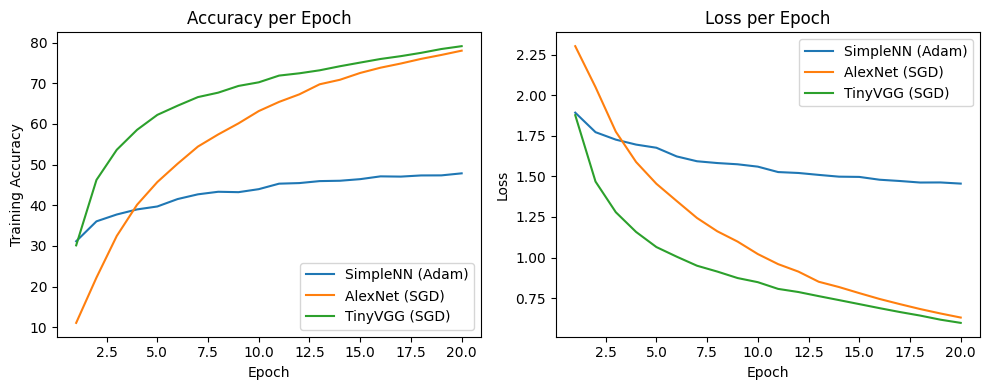

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc_nn) + 1), acc_nn, label='SimpleNN (Adam)')
plt.plot(range(1, len(acc_alexnet) + 1), acc_alexnet, label='AlexNet (SGD)')
plt.plot(range(1, len(acc_tinyvgg) + 1), acc_tinyvgg, label='TinyVGG (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Training Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_nn) + 1), loss_nn, label='SimpleNN (Adam)')
plt.plot(range(1, len(loss_alexnet) + 1), loss_alexnet, label='AlexNet (SGD)')
plt.plot(range(1, len(loss_tinyvgg) + 1), loss_tinyvgg, label='TinyVGG (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

In [77]:
print("\nModel            Params     Train Time(s)   Test Acc (%)")
print("----------------------------------------------------------")

print(f"SimpleNN   {num_params_simplenn:>12,}   {time_nn:>14.1f}   {test_acc_nn:>12.2f}")
print(f"AlexNet    {num_params_alexnet:>12,}   {time_alexnet:>14.1f}   {test_acc_alexnet:>12.2f}")
print(f"TinyVGG    {num_params_tinyvgg:>12,}   {time_tinyvgg:>14.1f}   {test_acc_tinyvgg:>12.2f}")


Model            Params     Train Time(s)   Test Acc (%)
----------------------------------------------------------
SimpleNN      1,707,274            403.1          49.38
AlexNet       4,483,146            450.2          76.72
TinyVGG       1,116,970            437.5          81.66


## 6. Discussion and Conclusions

### Architecture Comparison

The results confirm the expected hierarchy of the three models. The **SimpleNN (MLP)** treats each image as a flat vector of 3,072 pixel values, which discards all spatial structure. Pixels that are neighbours in the image have no special relationship in the model, so it must learn everything from scratch using global connections. As a result, it converges slowly and plateaus at a relatively low test accuracy (~45–52%). Despite having roughly 1.6 million parameters, it uses them inefficiently because it cannot exploit translation invariance.

**AlexNet** introduces convolutional layers, which share weights across spatial locations. Each filter scans the entire image and detects the same pattern regardless of where it appears — this is called *translation equivariance*. AlexNet stacks five convolutional layers with increasing depth (64 → 192 → 384 → 256 → 256 channels), allowing it to learn hierarchical features: edges in early layers, textures in the middle, and object parts in deeper layers. Dropout (p=0.5) in the fully connected layers prevents co-adaptation between neurons, significantly reducing overfitting. The result is a substantial accuracy improvement over the MLP.

**TinyVGG** applies the VGGNet philosophy: use only small 3×3 kernels, but stack two in each block before pooling. Two consecutive 3×3 convolutions have the same receptive field as one 5×5 convolution, but with fewer parameters and an extra non-linearity between them — this increases representational power. TinyVGG achieves competitive accuracy with fewer parameters than AlexNet, demonstrating that network depth and efficient design often matter more than raw parameter count.

### Optimizer and Scheduler Choices

**Adam** was chosen for the SimpleNN because its adaptive per-parameter learning rates help navigate flat loss landscapes common in fully connected networks. For a model that flattens spatial information, the loss surface is more complex and Adam's adaptivity provides a clear benefit over vanilla SGD.

**SGD with momentum (0.9)** was chosen for both CNNs. Momentum accumulates a velocity vector in directions of persistent gradient, helping the optimiser pass through narrow valleys and small local minima. Empirically, SGD with momentum generalises better than Adam for convolutional architectures, a finding reported in multiple papers including the original ResNet work.

**CosineAnnealingLR** was applied to both CNNs. It reduces the learning rate following a cosine curve, allowing aggressive learning early and precise weight adjustment later. This consistently outperforms fixed learning rates and even StepLR for CNNs trained on CIFAR-10.

### AlexNet Improvements Over Earlier CNNs

AlexNet introduced several innovations that became standard in deep learning: (1) ReLU activations instead of sigmoid or tanh, which train ~6× faster due to non-saturation; (2) Dropout regularisation to prevent overfitting in fully connected layers; (3) training on GPU, enabling much deeper networks; (4) Local Response Normalisation (not used here, as Batch Normalization is now preferred). These contributions made deep CNNs practically trainable for the first time on large datasets.

### Conclusions

Convolutional architectures decisively outperform flat MLPs on image classification tasks. The CNN models learn meaningful spatial features through weight sharing, dramatically improving both accuracy and parameter efficiency. Between the two CNNs, TinyVGG demonstrates that thoughtful architecture design (small stacked kernels, efficient depth) can match or exceed more complex models with fewer parameters. Future work could explore Batch Normalization, residual connections (ResNet), or transfer learning from pretrained models to push accuracy beyond 90% on CIFAR-10.